### Nicholas Wong
### UNI: nzw2002


# Part I: Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

## 1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [24]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv").drop(['Unnamed: 0'], axis = 1)

In [25]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


## 2) Convert `default` and `student` to categorical variables.

In [27]:
# Convert 'default' to categorical
df['default'] = pd.Series(np.where(df['default'].values == 'Yes', 1, 0), df["default"].index)

# View head()
df['default'].head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int32

In [28]:
# Convert 'student' to categorical
df['student'] = pd.Series(np.where(df["student"].values == 'Yes', 1, 0), df["student"].index)

# View head()
df['student'].head()

0    0
1    1
2    0
3    0
4    0
Name: student, dtype: int32

## 3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of `default` labeled red if yes and blue if no. 

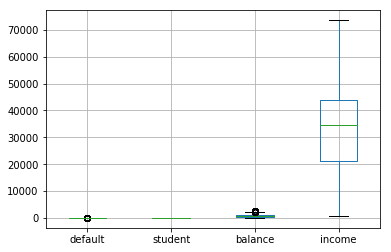

In [29]:
# Make boxplots
df.boxplot()
plt.show()

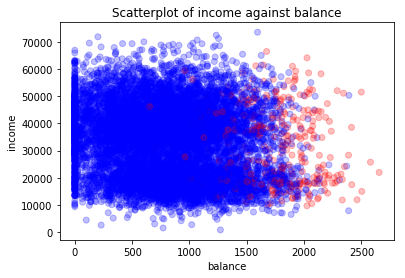

In [33]:
# Make scatterplot

colors= df ["default"]
colors = colors.replace(1,"r").replace(0,"b")
plt.scatter(df['balance'], df['income'], c = colors, alpha = 0.25)
plt.title('Scatterplot of income against balance')
plt.xlabel('balance')
plt.ylabel('income')
plt.show()

From the scatterplot we can observe that having a high balance is a significant indicator of default potential regardless of income.

## 4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based solely on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [121]:
X, y = df.loc[:,['balance', 'income']], df.loc[:,'default']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [123]:
lr = LogisticRegression(class_weight = 'balanced', penalty='l1').fit(X_train,y_train)

### Plot decision boundary of logistic regression

In [124]:
w = lr.coef_.flatten()
b = lr.intercept_
x = np.arange(0, 2600, 1)
boundary = (w[0] * x + b)/-w[1] 

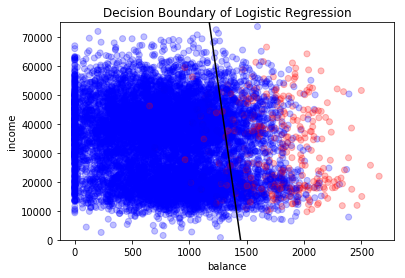

In [125]:
plt.scatter(df['balance'], df['income'], c = colors, alpha = 0.25)
plt.title('Decision Boundary of Logistic Regression')
plt.xlabel('balance')
plt.ylabel('income')
plt.ylim(0, 75000)
plt.plot(x, boundary, c = 'black')
plt.show()

As seen in the plot above, the decision boundary is successful in sequestering almost all of the defaulters to one side of the boundary with only a few false negatives, which indicates a high *recall* value. However, its *precision* seems to be a bit lacking since there are quite a number of false positives as well.

### Plot and obtain AUC ROC

Area under the ROC curve : 0.9493464802821285


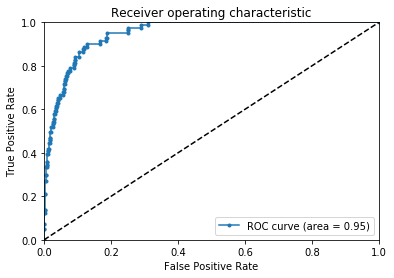

In [181]:
def generate_auc(xtest, ytest, classifier):
    probas_ = classifier.predict_proba(xtest)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : {}".format(roc_auc))
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X_test, y_test, lr)

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

## 5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients.  How does performance improve with the added variable?

In [107]:
X1 = df.loc[:,["balance", "income", "student"]]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, random_state = 42)

In [108]:
lr1 = LogisticRegression(class_weight = 'balanced', penalty = "l2").fit(X_train1, y_train1)

### Plot Decision Boundary

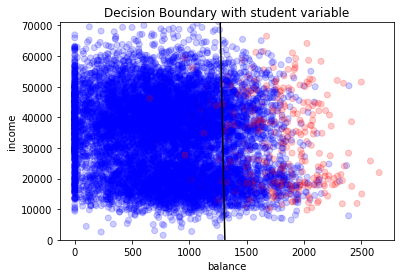

In [189]:
w = lr1.coef_.flatten()
b = lr1.intercept_
x = np.arange(0, 2600, 100)
boundary_1 = (b + w[0] * x) / -w[1]
plt.ylim(0, 71000)
plt.scatter(x = df.balance, y = df.income, c = colors, alpha = 0.2)
plt.plot(x, boundary_1, c='black')
plt.xlabel('balance')
plt.ylabel('income')
plt.title('Decision Boundary with student variable')
plt.show()

### Plot AUC ROC

Area under the ROC curve : 0.9506479057257615


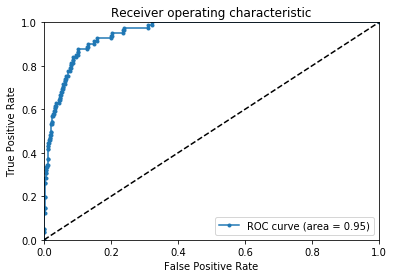

In [182]:
fpr, tpr, roc_auc, thresholds = generate_auc(X_test1, y_test1, lr1)
generate_ROCplot(fpr, tpr,'LR', roc_auc)

There seems to be a marginal improvement in the AUC score, which has gone up to ~0.951 from 0.949 in the model in Q4) above.

### Ranking of Coefficients

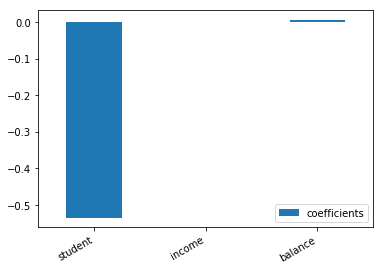

In [185]:
coeffs = pd.DataFrame(lr1.coef_[0], columns=['coefficients'], index = X1.columns) 
coeffs.sort_values('coefficients').plot(kind='bar')
plt.xticks(rotation=30, ha='right')
plt.show()

## 6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [141]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

scores = cross_val_score(LogisticRegression(class_weight='balanced', penalty = "l2"), 
                         X_train1, y_train1, scoring='roc_auc', cv = cv ) 

print("ROC AUC scores: ", scores)

ROC AUC scores:  [0.94907162 0.95909814 0.96347586 0.92788966 0.96595862 0.93274483
 0.95630345 0.96286897 0.92651934 0.93707182]


In [142]:
print("Mean Cross-Validation ROC_AUC Score: {:.3f}".format(np.mean(scores))) 

Mean Cross-Validation ROC_AUC Score: 0.948


The ROC AUC scores for each fold of the 10-fold cross-validation all seem to be consistent, with a mean of about **0.948**. This indicates that the model built in 5) is robust and generalizes to random folds of the dataset.

## 7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [139]:
scores = cross_val_score(DecisionTreeClassifier(max_depth = 5, random_state = 42, class_weight = "balanced"), 
                                             X_train1, y_train1, scoring='roc_auc', cv = cv ) 

print("ROC AUC scores: ", scores)

ROC AUC scores:  [0.94779841 0.88771883 0.86868966 0.78353103 0.9416     0.93263448
 0.9529931  0.93205517 0.92566298 0.87574586]


In [140]:
print("Mean Cross-Validation ROC_AUC Score: {:.3f}".format(np.mean(scores))) 

Mean Cross-Validation ROC_AUC Score: 0.905


Performance with the decision tree classifier has decreased compared to the logistic regression with a ridge penalty.

## 8) Find the optimal decision tree depth and compute the AUC ROC. 

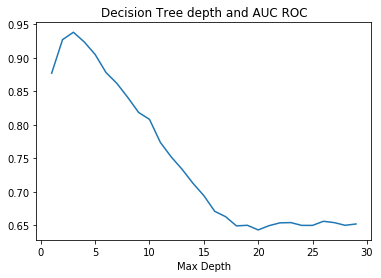

Optimal Decision Tree depth: 3
Optimal Training Score 0.9380035253601416


In [191]:
params = np.arange(1,30)
scores = []
for p in params:
    tree = DecisionTreeClassifier(class_weight = "balanced", max_depth = p, random_state = 1234)
    scores.append(np.mean(cross_val_score(tree, X_train1, y_train1, scoring='roc_auc', cv = cv)))
plt.plot(params, scores)
plt.title("Decision Tree depth and AUC ROC")
plt.xlabel("Max Depth")
plt.show()
print("Optimal Decision Tree depth: {}".format(np.argmax(scores) + 1))
print("Optimal Training Score {}".format(np.max(scores)))

In [193]:
tree = DecisionTreeClassifier(class_weight = "balanced", max_depth = 3, random_state = 1234)
tree.fit(X_train1, y_train1)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

Area under the ROC curve : 0.9345765774041921


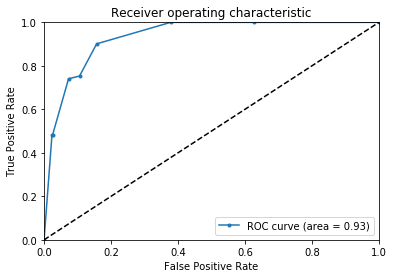

In [195]:
fpr,tpr,roc_auc, thresholds = generate_auc(X_test1, y_test1, tree)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

Performance as measured by AUC improves after tuning the *max_depth* parameter, but is still below that of the logistic regression model regularized with a ridge penalty.

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 